## Aircraft wildlife strike data analysis

Objective: Predict cost of repairs and/or replacement in USD for aircrafts, more specifically airplanes that encountered wildlife strike using wildlife strike reports gathered by the Federal Aviation Administration from 1990 to 2024.

Source: https://wildlife.faa.gov/search

In [1]:
import pandas as pd

wildlife_strike_data = pd.read_excel('/Users/jiajue/Documents/McGill/Winter Term/INSY695/Assignment/wildlife strike data/Strike_Reports.xlsx')

### Inspect data structure

In [2]:
# Inspect data
wildlife_strike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310738 entries, 0 to 310737
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   INDEX_NR               310738 non-null  int64         
 1   INCIDENT_DATE          310738 non-null  datetime64[ns]
 2   INCIDENT_MONTH         310738 non-null  int64         
 3   INCIDENT_YEAR          310738 non-null  int64         
 4   TIME                   176706 non-null  object        
 5   TIME_OF_DAY            175264 non-null  object        
 6   AIRPORT_ID             310738 non-null  object        
 7   AIRPORT                310738 non-null  object        
 8   AIRPORT_LATITUDE       271332 non-null  float64       
 9   AIRPORT_LONGITUDE      271331 non-null  float64       
 10  RUNWAY                 234935 non-null  object        
 11  STATE                  271332 non-null  object        
 12  FAAREGION              271332 non-null  obj

In [3]:
wildlife_strike_data.head()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,1996-06-22,6,1996,NaN,NaN,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,False
1,608243,1996-06-26,6,1996,NaN,NaN,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,False
2,608244,1996-07-01,7,1996,NaN,NaN,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,False
3,608245,1996-07-01,7,1996,NaN,NaN,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,False
4,608246,1996-07-01,7,1996,NaN,NaN,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,2007-12-20,False


### Pre-processing

In [4]:
# Set up relevant columns to retain
cols_to_keep = ['INCIDENT_MONTH', 'TIME','TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'AIRCRAFT', 'EMA', 'EMO', 'AC_CLASS', 'AC_MASS', 'TYPE_ENG', 'NUM_ENGS', 'ENG_1_POS', 'ENG_2_POS', 'ENG_3_POS', 'ENG_4_POS', 'SPEED', 'SKY', 'PRECIPITATION', 'PHASE_OF_FLIGHT', 'DAMAGE_LEVEL', 'DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_ENG1', 'ING_ENG1', 'DAM_ENG2', 'ING_ENG2', 'DAM_ENG3', 'ING_ENG3', 'DAM_ENG4', 'ING_ENG4', 'INGESTED_OTHER', 'DAM_PROP', 'DAM_WING_ROT', 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER', 'NUM_STRUCK', 'SPECIES', 'SIZE', 'AOS', 'COST_REPAIRS_INFL_ADJ']
# ICAO aircraft make and model dictionary unavailable
# Airport ID, longitude/latitude points to the types of birds in the vicinity
# EMA, EMO: Engine

# Keep a copy for easier manipulation
wildlife_strike = wildlife_strike_data.copy()
wildlife_strike = wildlife_strike[cols_to_keep]
wildlife_strike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310738 entries, 0 to 310737
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         310738 non-null  int64  
 1   TIME                   176706 non-null  object 
 2   TIME_OF_DAY            175264 non-null  object 
 3   AIRPORT_ID             310738 non-null  object 
 4   AIRPORT_LATITUDE       271332 non-null  float64
 5   AIRPORT_LONGITUDE      271331 non-null  float64
 6   AIRCRAFT               310738 non-null  object 
 7   EMA                    206258 non-null  float64
 8   EMO                    198430 non-null  float64
 9   AC_CLASS               221924 non-null  object 
 10  AC_MASS                221806 non-null  float64
 11  TYPE_ENG               221450 non-null  object 
 12  NUM_ENGS               221544 non-null  float64
 13  ENG_1_POS              221524 non-null  float64
 14  ENG_2_POS              205792 non-nu

### Time investigation

Rationale: Time of day affects availability of resources, severity of strike, airport operations, and may also coincide with specific weather conditions, which affect repair needs.

In [5]:
wildlife_strike['TIME_OF_DAY'].unique()

array([nan, 'Day', 'Dawn', 'Night', 'Dusk'], dtype=object)

In [6]:
import datetime

def assign_time_of_day(row):
    time = row['TIME']
    month = row['INCIDENT_MONTH']
    if pd.isna(time):
        return None  # Skip if TIME is missing
    
    # Convert TIME to datetime if not already
    time = pd.to_datetime(time, format='%H:%M', errors='coerce').time()
    if not time:
        return None
    
    # Define time ranges for summer and winter
    summer = [5, 6, 7, 8]
    winter = [11, 12, 1, 2]
    
    # Adjust categories based on season
    if month in summer:
        if time >= datetime.time(4, 0) and time < datetime.time(6, 0):
            return 'Dawn'
        elif time >= datetime.time(6, 0) and time < datetime.time(20, 0):
            return 'Day'
        elif time >= datetime.time(20, 0) and time < datetime.time(21, 30):
            return 'Dusk'
        else:
            return 'Night'
    elif month in winter:
        if time >= datetime.time(6, 0) and time < datetime.time(7, 30):
            return 'Dawn'
        elif time >= datetime.time(7, 30) and time < datetime.time(17, 30):
            return 'Day'
        elif time >= datetime.time(17, 30) and time < datetime.time(18, 30):
            return 'Dusk'
        else:
            return 'Night'
    else:  # Transitional months (e.g., March, April, September, October)
        if time >= datetime.time(5, 0) and time < datetime.time(7, 0):
            return 'Dawn'
        elif time >= datetime.time(7, 0) and time < datetime.time(19, 0):
            return 'Day'
        elif time >= datetime.time(19, 0) and time < datetime.time(20, 30):
            return 'Dusk'
        else:
            return 'Night'

# Apply the function to the dataset
wildlife_strike['TIME_OF_DAY'] = wildlife_strike.apply(assign_time_of_day, axis=1)

In [7]:
# Verify time of day has been filled up
print('Number of entries without \'time of day\' filled in using precise timing: ', wildlife_strike[wildlife_strike['TIME_OF_DAY'].isna() & wildlife_strike['TIME'].notna()].shape[0])

# Drop time col then remove all rows without time of day filled in
wildlife_strike = wildlife_strike.drop(columns=['TIME'])
wildlife_strike = wildlife_strike.dropna(subset=['TIME_OF_DAY'])

wildlife_strike.info()

Number of entries without 'time of day' filled in using precise timing:  0
<class 'pandas.core.frame.DataFrame'>
Index: 176706 entries, 10 to 310726
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         176706 non-null  int64  
 1   TIME_OF_DAY            176706 non-null  object 
 2   AIRPORT_ID             176706 non-null  object 
 3   AIRPORT_LATITUDE       161225 non-null  float64
 4   AIRPORT_LONGITUDE      161224 non-null  float64
 5   AIRCRAFT               176706 non-null  object 
 6   EMA                    140548 non-null  float64
 7   EMO                    134020 non-null  float64
 8   AC_CLASS               152365 non-null  object 
 9   AC_MASS                152276 non-null  float64
 10  TYPE_ENG               152043 non-null  object 
 11  NUM_ENGS               152072 non-null  float64
 12  ENG_1_POS              152064 non-null  float64
 13  ENG_2_POS         

### Inspect aircraft, aircraft type and mass

Aircraft mass refers to maximum take-off mass, rather than the actual aircraft mass. Includes weight, fuel load, passengers and cargo & auxillary equipment

In [8]:
# Investigate aircraft & aircraft type
pd.set_option('display.max_rows', None)
print('Aircrafts with missing aircraft type\n', wildlife_strike[wildlife_strike['AC_CLASS'].isna()]['AIRCRAFT'].value_counts())

# Drop all rows with missing aircrafts - no way to map aircraft type
wildlife_strike_air = wildlife_strike[
    ~wildlife_strike['AC_CLASS'].isna()]

wildlife_strike_air.info()

Aircrafts with missing aircraft type
 AIRCRAFT
UNKNOWN                  24047
EXPERIMENTAL               249
DRONE                       23
MILITARY                    19
Unknown                      1
BOMBARDIER                   1
CL-600-2C10 / CRJ 700        1
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 152365 entries, 10 to 310726
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         152365 non-null  int64  
 1   TIME_OF_DAY            152365 non-null  object 
 2   AIRPORT_ID             152365 non-null  object 
 3   AIRPORT_LATITUDE       137027 non-null  float64
 4   AIRPORT_LONGITUDE      137026 non-null  float64
 5   AIRCRAFT               152365 non-null  object 
 6   EMA                    140478 non-null  float64
 7   EMO                    133957 non-null  float64
 8   AC_CLASS               152365 non-null  object 
 9   AC_MASS        

In [9]:
# Verify no missing value of aircraft type or aircraft
wildlife_strike_air[wildlife_strike_air['AC_CLASS'].isna() | wildlife_strike_air['AIRCRAFT'].isna()].value_counts()

Series([], Name: count, dtype: int64)

In [10]:
# Check the distribution of aircraft classes
wildlife_strike_air['AC_CLASS'].value_counts()

# huge imbalance in data - data is mainly on airplanes. narrow down to focus on airplanes

# Filter the DataFrame to include only aircraft class A
wildlife_strike_airplane = wildlife_strike_air[wildlife_strike_air['AC_CLASS']=='A']

### Dataset has been filtered to consider only airplanes due to huge imbalances in airstrike reports. 

In [11]:
# Inspect entries with missing aircraft mass
wildlife_strike_airplane[wildlife_strike_airplane['AC_MASS'].isna()][['AC_CLASS', 'AIRCRAFT']].value_counts()

# Only AC-130 aircraft is a specific aircraft model. max weight for take off = 70307kg
wildlife_strike_airplane.loc[wildlife_strike_airplane['AIRCRAFT'] == 'AC-130', 'AC_MASS'] = 4

# Rest of them are not specific aircrafts - just the manufacturer. to drop the rest with missing mass
wildlife_strike_airplane.dropna(subset=['AC_MASS'], inplace=True)

# Drop aircraft class as well since all of the entries are airplanes
wildlife_strike_airplane.drop('AC_CLASS', axis=1, inplace=True)

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/2323919096.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildlife_strike_airplane.dropna(subset=['AC_MASS'], inplace=True)
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/2323919096.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildlife_strike_airplane.drop('AC_CLASS', axis=1, inplace=True)


In [12]:
# Mass mapping
mass_map = {
    '1.0': '2250 or less', 
    '2.0': '2251-5700',
    '3.0': '5701-27000',
    '4.0': '27001-272000',
    '5.0': '272001 or more'
}

wildlife_strike_airplane['AC_MASS'] = wildlife_strike_airplane['AC_MASS'].astype(str)
wildlife_strike_airplane['AC_MASS'] = wildlife_strike_airplane['AC_MASS'].map(mass_map)

# Verify right mapping done
wildlife_strike_airplane['AC_MASS'].unique()

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/1778850953.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildlife_strike_airplane['AC_MASS'] = wildlife_strike_airplane['AC_MASS'].astype(str)
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/1778850953.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildlife_strike_airplane['AC_MASS'] = wildlife_strike_airplane['AC_MASS'].map(mass_map)


array(['2250 or less', '27001-272000', '2251-5700', '272001 or more',
       '5701-27000'], dtype=object)

In [13]:
# Inspect the aircrafts count
wildlife_strike_airplane['AIRCRAFT'].value_counts()

# Name harmonisation
import re

# Function to extract the part before the second dash using regex
def extract_aircraft_category(name):
    match = re.match(r'([A-Za-z0-9]+-[A-Za-z0-9]+)', name)
    if match:
        return match.group(0)
    else:
        return name

# Apply the regex to standardize the names
wildlife_strike_airplane['CATEGORY'] = wildlife_strike_airplane['AIRCRAFT'].apply(extract_aircraft_category)

wildlife_strike_airplane['CATEGORY'].value_counts()

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/2731686954.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildlife_strike_airplane['CATEGORY'] = wildlife_strike_airplane['AIRCRAFT'].apply(extract_aircraft_category)


CATEGORY
B-737                       34903
A-320                       10738
CRJ100/200                   7855
EMB-170                      7669
A-319                        6571
A-321                        5596
B-757                        5086
EMB-145                      4795
B-767                        4015
CRJ900                       3942
CRJ700                       3475
A-300                        3235
C-172                        2979
B-717                        2434
DHC8 DASH 8                  2129
MD-11                        1853
B-727                        1662
DC-10                        1651
PA-28                        1561
MD-82                        1520
EMB-190                      1451
MD-88                        1432
MD-83                        1383
EMB-135                      1313
B-777                        1275
DC-9                          874
C-560                         777
SAAB-340                      704
CIRRUS SR 20/22               677
BE-19

### Wildlife strike considerations: size and the number struck 

Rationale: Both combined directly impacts the level of damage and costs of repair. Either one that is missing will result in accurate predictions.

In [14]:
# Check for rows where species is present while size is not to fill in the missing value
print('Entries with species present but missing size', wildlife_strike_airplane[wildlife_strike_airplane['SPECIES'].notna() & wildlife_strike_airplane['SIZE'].isna()].value_counts())

# Since there is a size indicated for all entries with species, species can be dropped. 

Entries with species present but missing size Series([], Name: count, dtype: int64)


In [15]:
# Eliminate rows with missing number of wildlife strike or size - both combined
wildlife_strike_bird = wildlife_strike_airplane[~(wildlife_strike_airplane['NUM_STRUCK'].isna() | wildlife_strike_airplane['SIZE'].isna())]

# Inspect size and number struck variables
print('Size distribution of wildlife struck:', wildlife_strike_bird['SIZE'].value_counts())

print('\nDistribution of number of wildlife struck:', wildlife_strike_bird['NUM_STRUCK'].value_counts())

# Drop species column
wildlife_strike_bird = wildlife_strike_bird.drop('SPECIES', axis=1)

wildlife_strike_bird.info()

Size distribution of wildlife struck: SIZE
Small     88496
Medium    27315
Large      9354
Name: count, dtype: int64

Distribution of number of wildlife struck: NUM_STRUCK
1                106461
2-10              17654
11-100             1019
More than 100        31
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 125165 entries, 10 to 310726
Data columns (total 44 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         125165 non-null  int64  
 1   TIME_OF_DAY            125165 non-null  object 
 2   AIRPORT_ID             125165 non-null  object 
 3   AIRPORT_LATITUDE       114859 non-null  float64
 4   AIRPORT_LONGITUDE      114858 non-null  float64
 5   AIRCRAFT               125165 non-null  object 
 6   EMA                    116827 non-null  float64
 7   EMO                    112011 non-null  float64
 8   AC_MASS                125165 non-null  object 
 9   TYPE_ENG   

In [16]:
# Couns the number of unique AC_MASS values for each AIRCRAFT
aircraft_mass_check = wildlife_strike_bird.groupby('AIRCRAFT')['AC_MASS'].nunique()

# Get the aircrafts with more than one unique AC_MASS
multi_mass_aircraft = aircraft_mass_check[aircraft_mass_check > 1].index

# Filter the rows in wildlife_strike_bird where AIRCRAFT has more than one unique AC_MASS
result = wildlife_strike_bird[wildlife_strike_bird['AIRCRAFT'].isin(multi_mass_aircraft)]

print(result[['AIRCRAFT', 'AC_MASS']])

# verified consistent entries for aircraft and masses

Empty DataFrame
Columns: [AIRCRAFT, AC_MASS]
Index: []


### Investigate precipitation & sky conditions 

In [17]:
# Find unique precipitation types reported
print(wildlife_strike_bird['PRECIPITATION'].unique())
print(wildlife_strike_bird['SKY'].unique())

# Applicability in this use case seems rather low, as the target here is repair cost. 

# Drop columns
wildlife_strike_bird.drop(columns=['PRECIPITATION', 'SKY'], inplace=True)
wildlife_strike_bird.info()

[nan 'Fog' 'Rain' 'Snow' 'Fog, Rain' 'Rain, Snow' 'Fog, Rain, Snow'
 'Fog, Snow' 'None, Rain' 'None, Snow']
['No Cloud' 'Some Cloud' 'Overcast' nan]
<class 'pandas.core.frame.DataFrame'>
Index: 125165 entries, 10 to 310726
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         125165 non-null  int64  
 1   TIME_OF_DAY            125165 non-null  object 
 2   AIRPORT_ID             125165 non-null  object 
 3   AIRPORT_LATITUDE       114859 non-null  float64
 4   AIRPORT_LONGITUDE      114858 non-null  float64
 5   AIRCRAFT               125165 non-null  object 
 6   EMA                    116827 non-null  float64
 7   EMO                    112011 non-null  float64
 8   AC_MASS                125165 non-null  object 
 9   TYPE_ENG               125147 non-null  object 
 10  NUM_ENGS               125163 non-null  float64
 11  ENG_1_POS              125159 non-null  float64
 1

### Investigate speed of aircraft on impact

Rationale: Laws of physics. Larger the momentum, greater the impact, and thus repair. Phase of flight values will be used to impute the missing values in speed. 

In [18]:
# Understanding the phase of flight and the speeds of aircraft on strike
print(wildlife_strike_bird.groupby('PHASE_OF_FLIGHT')['SPEED'].mean())
wildlife_strike_bird.groupby('PHASE_OF_FLIGHT')['SPEED'].median()

PHASE_OF_FLIGHT
Approach        150.506678
Arrival         113.750000
Climb           165.374806
Departure       134.375000
Descent         244.844784
En Route        142.871508
Landing Roll    107.011388
Local           126.158824
Parked            0.000000
Take-off Run    115.777677
Taxi             22.945455
Unknown         215.000000
Name: SPEED, dtype: float64


PHASE_OF_FLIGHT
Approach        140.0
Arrival         115.0
Climb           160.0
Departure       142.5
Descent         250.0
En Route        125.0
Landing Roll    110.0
Local           130.0
Parked            0.0
Take-off Run    120.0
Taxi             10.0
Unknown         215.0
Name: SPEED, dtype: float64

In [19]:
# Fill in missing values of speed based on the median 
# First drop the rows with unknown phase of flight
wildlife_strike_speed = wildlife_strike_bird[wildlife_strike_bird['PHASE_OF_FLIGHT'] != 'Unknown']

# Calculate the median SPEED for each PHASE_OF_FLIGHT
phase_medians = wildlife_strike_speed.groupby('PHASE_OF_FLIGHT')['SPEED'].median()

# Fill missing SPEED values with the corresponding median values
wildlife_strike_speed['SPEED'] = wildlife_strike_speed['SPEED'].fillna(
    wildlife_strike_speed['PHASE_OF_FLIGHT'].map(phase_medians)
)

# Drop the remaining entries with missing speed and drop phase of flight col
wildlife_strike_speed = wildlife_strike_speed.dropna(subset=['SPEED'])
wildlife_strike_speed = wildlife_strike_speed.drop('PHASE_OF_FLIGHT', axis=1)

wildlife_strike_speed.info() 
# prior to filling speed missing values: 64120 non null
# after filling speed: 115874

<class 'pandas.core.frame.DataFrame'>
Index: 115874 entries, 10 to 310726
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         115874 non-null  int64  
 1   TIME_OF_DAY            115874 non-null  object 
 2   AIRPORT_ID             115874 non-null  object 
 3   AIRPORT_LATITUDE       114548 non-null  float64
 4   AIRPORT_LONGITUDE      114547 non-null  float64
 5   AIRCRAFT               115874 non-null  object 
 6   EMA                    108132 non-null  float64
 7   EMO                    104035 non-null  float64
 8   AC_MASS                115874 non-null  object 
 9   TYPE_ENG               115858 non-null  object 
 10  NUM_ENGS               115872 non-null  float64
 11  ENG_1_POS              115868 non-null  float64
 12  ENG_2_POS              108124 non-null  float64
 13  ENG_3_POS              6490 non-null    float64
 14  ENG_4_POS              1396 non-null    

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/3600484971.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildlife_strike_speed['SPEED'] = wildlife_strike_speed['SPEED'].fillna(


### Investigate damage and costs to aircraft

If there is no damage / ingestion that occurred, there should not be any *repair cost* to the aircraft as a result of the wildlife strike. 

In [20]:
# Set up var pertaining to damage
damage_components = ['DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4', 'DAM_PROP', 'DAM_WING_ROT', 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER']
ingestion = ['ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4', 'INGESTED_OTHER']

# To confirm the components in above var exist in dataset
missing_cols = [col for col in damage_components if col not in wildlife_strike_speed.columns]
print("Number of missing columns:", len(missing_cols))

Number of missing columns: 0


In [21]:
# Fill in damage level with N if all damage components are false
wildlife_strike_speed.loc[wildlife_strike_speed[damage_components].sum(axis=1) == 0, 'DAMAGE_LEVEL'] = 'N'

# Extract rows with all damage components = False to investigate cost col
no_damage = wildlife_strike_speed[~wildlife_strike_speed[damage_components].any(axis=1)]

# Check if any ingestion occurred for the aircrafts without damage
pd.set_option('display.max_columns', None)
no_damage[no_damage['COST_REPAIRS_INFL_ADJ'].notna() & no_damage[ingestion].any(axis=1)]

# Look at the costs incurred in repairs for reports that reported no damage
no_damage[no_damage['COST_REPAIRS_INFL_ADJ'].notna()]

,INCIDENT_MONTH,TIME_OF_DAY,AIRPORT_ID,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,AIRCRAFT,EMA,EMO,AC_MASS,TYPE_ENG,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,SPEED,DAMAGE_LEVEL,DAM_RAD,DAM_WINDSHLD,DAM_NOSE,DAM_ENG1,ING_ENG1,DAM_ENG2,ING_ENG2,DAM_ENG3,ING_ENG3,DAM_ENG4,ING_ENG4,INGESTED_OTHER,DAM_PROP,DAM_WING_ROT,DAM_FUSE,DAM_LG,DAM_TAIL,DAM_LGHTS,DAM_OTHER,NUM_STRUCK,SIZE,AOS,COST_REPAIRS_INFL_ADJ,CATEGORY
267346,9,Dusk,KORD,41.97960,-87.90446,B-777-300,22.0,NaN,272001 or more,D,2.0,1.0,1.0,NaN,NaN,120.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2-10,Small,50.0,365000.0,B-777
267723,9,Night,KUNV,40.84928,-77.84869,EMB-170,22.0,4.0,27001-272000,D,2.0,1.0,1.0,NaN,NaN,140.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Small,1.0,630.0,EMB-170
269979,10,Night,KMSP,44.88055,-93.21692,B-737-8,10.0,NaN,27001-272000,D,2.0,1.0,1.0,NaN,NaN,150.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Small,1.0,100.0,B-737
270646,10,Night,KISP,40.79524,-73.10021,B-737-800,10.0,NaN,27001-272000,D,2.0,1.0,1.0,NaN,NaN,145.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Medium,2.0,200.0,B-737
273745,11,Day,KONT,34.05600,-117.60119,B-737-800,10.0,1.0,27001-272000,D,2.0,1.0,1.0,NaN,NaN,110.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Small,NaN,300.0,B-737
304965,7,Day,KDEN,39.85841,-104.66700,B-737-8,10.0,NaN,27001-272000,D,2.0,1.0,1.0,NaN,NaN,140.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Small,45.0,200.0,B-737
306219,7,Day,KAUS,30.19453,-97.66987,B-737-8,10.0,NaN,27001-272000,D,2.0,1.0,1.0,NaN,NaN,140.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2-10,Small,1.0,1000.0,B-737
308850,8,Day,KAUS,30.19453,-97.66987,B-737-8,10.0,NaN,27001-272000,D,2.0,1.0,1.0,NaN,NaN,150.0,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Small,1.0,100.0,B-737


In [22]:
# Understand values of damage level of reports
print(no_damage['DAMAGE_LEVEL'].value_counts()) # Damage level N = no damage reported

# Fill 0 in na rows where entries correspond to those in no_damage
wildlife_strike_speed['COST_REPAIRS_INFL_ADJ'] = wildlife_strike_speed.apply(
    lambda row: 0 if row.name in no_damage.index and pd.isna(row['COST_REPAIRS_INFL_ADJ']) else row['COST_REPAIRS_INFL_ADJ'],
    axis=1
)

DAMAGE_LEVEL
N    105717
Name: count, dtype: int64


In [23]:
# Filter rows in wildlife_strike_speed where COST_REPAIRS_INFL_ADJ is missing
missing_cost = wildlife_strike_speed[wildlife_strike_speed['COST_REPAIRS_INFL_ADJ'].isna()]
len(missing_cost)

# Inspect damage level col of missing cost subset
missing_cost['DAMAGE_LEVEL'].value_counts()

# Fill in 0 in cost where damage level is N if cost is na
wildlife_strike_speed.loc[
    wildlife_strike_speed['COST_REPAIRS_INFL_ADJ'].isna() & 
    wildlife_strike_speed['DAMAGE_LEVEL'].isin(['0', 'N']), 
    'COST_REPAIRS_INFL_ADJ'] = 0

In [24]:
# Condition that specifies all ingestion and damage components are False but COST_REPAIRS_INFL_ADJ > 0 -- indicates potentially wrong entries
condition = (
    (wildlife_strike_speed[ingestion].sum(axis=1) == 0) &  # All ingestion components are False
    (wildlife_strike_speed[damage_components].sum(axis=1) == 0) &  # All damage components are False
    (wildlife_strike_speed['COST_REPAIRS_INFL_ADJ'] > 0)  # COST_REPAIRS_INFL_ADJ > 0
)

# Remove rows that satisfy the condition
wildlife_strike_damage = wildlife_strike_speed[~condition]
wildlife_strike_damage.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115866 entries, 10 to 310726
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         115866 non-null  int64  
 1   TIME_OF_DAY            115866 non-null  object 
 2   AIRPORT_ID             115866 non-null  object 
 3   AIRPORT_LATITUDE       114540 non-null  float64
 4   AIRPORT_LONGITUDE      114539 non-null  float64
 5   AIRCRAFT               115866 non-null  object 
 6   EMA                    108124 non-null  float64
 7   EMO                    104033 non-null  float64
 8   AC_MASS                115866 non-null  object 
 9   TYPE_ENG               115850 non-null  object 
 10  NUM_ENGS               115864 non-null  float64
 11  ENG_1_POS              115860 non-null  float64
 12  ENG_2_POS              108116 non-null  float64
 13  ENG_3_POS              6490 non-null    float64
 14  ENG_4_POS              1396 non-null    

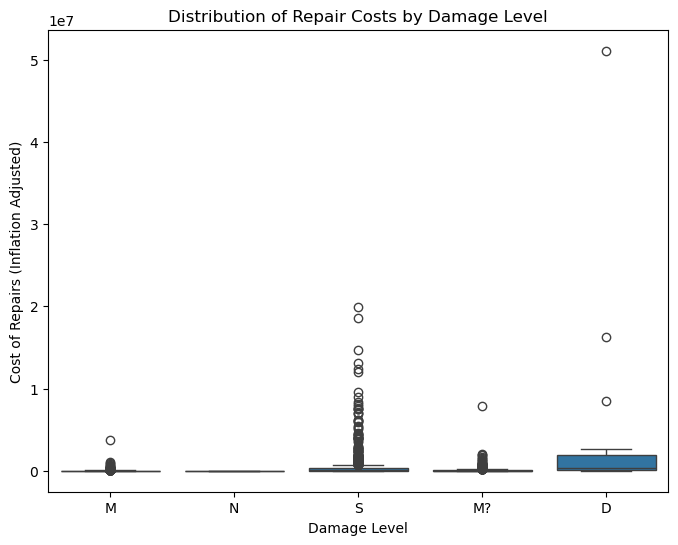

In [25]:
# Understand cost of repairs against damage level using plot
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='DAMAGE_LEVEL', y='COST_REPAIRS_INFL_ADJ', data=wildlife_strike_damage)

# Set plot title and labels
plt.title('Distribution of Repair Costs by Damage Level')
plt.xlabel('Damage Level')
plt.ylabel('Cost of Repairs (Inflation Adjusted)')

# Show the plot
plt.show()

In [26]:
# Drop missing values for cost due to huge variations in costs
wildlife_strike_damage = wildlife_strike_damage.dropna(subset=['COST_REPAIRS_INFL_ADJ'])

# Damage mapping dict
damage_map = {
    'N': 'None',
    'M': 'Minor',
    'M?': 'Undetermined',
    'S': 'Substantial',
    'D': 'Destroyed'
}

# Map over the relevant names
wildlife_strike_damage['DAMAGE_LEVEL'] = wildlife_strike_damage['DAMAGE_LEVEL'].map(damage_map)

# Verify the unique values are as indicated in dictionary
wildlife_strike_damage['DAMAGE_LEVEL'].unique()

array(['None', 'Substantial', 'Destroyed', 'Minor', 'Undetermined'],
      dtype=object)

### Inspect engine variables

In [27]:
# Get unique combinations of EMA and EMO, excluding rows with NA values
unique_combinations = wildlife_strike_damage[['EMA', 'EMO']].dropna()

# Count the occurrences of each unique combination of EMA and EMO
combination_counts = unique_combinations.groupby(['EMA', 'EMO']).size().reset_index(name='count')

# Display the unique combinations and their counts
print(combination_counts)

      EMA     EMO  count
0     1.0     1.0      3
1     1.0     4.0      9
2     1.0     7.0     11
3     1.0    10.0   4915
4     1.0    13.0      1
5     1.0    16.0      1
6     2.0     1.0     50
7     2.0     2.0      6
8     2.0     4.0      2
9     2.0     7.0      1
10    2.0  2301.0      1
11    3.0    10.0      1
12    3.0    31.0      1
13    7.0     1.0     12
14    7.0     3.0      1
15    7.0     7.0    282
16    7.0     8.0      3
17    7.0     9.0      2
18    7.0    10.0    972
19    7.0    13.0      3
20    7.0    16.0     11
21    7.0    19.0   1788
22    7.0    22.0      1
23    7.0    25.0     27
24    7.0    31.0    679
25    7.0    37.0      3
26    7.0    40.0      3
27    7.0    43.0     39
28    7.0    91.0      2
29    9.0     3.0    394
30    9.0     6.0   1872
31    9.0    12.0      1
32    9.0    16.0      1
33    9.0    34.0      1
34   10.0     1.0  29161
35   10.0     4.0      1
36   10.0     7.0      1
37   10.0    10.0      3
38   10.0    12.0      1


In [28]:
# Unique manufacturers & model codes
print('Number of unique manufacturers:', len(wildlife_strike_damage['EMA'].unique()))

# Count the number of unique combinations of EMA and EMO - indicate unique models
unique_combinations = wildlife_strike_damage[['EMA', 'EMO']].dropna().drop_duplicates()

# Print the number of unique combinations
print('Number of unique models:', len(unique_combinations))

# Engine manufacturers mapping based on dictionary codes
engin_manu_map = {
    '1': 'Allison',
    '2': 'Allied Signal',
    '4': 'Alvis',
    '7': 'Avo Lycoming',
    '8': 'Bristol',
    '9': 'BMW/RR',
    '10': 'CFM International',
    '11': 'CFE Company',
    '13': 'Continental',
    '16': 'Curtiss-Wright',
    '19': 'Garret Airesearch',
    '22': 'General Electric',
    '23': "Int'l Aero Engines",
    '24': 'Isotov',
    '25': 'Ivchenko',
    '27': 'Klimov',
    '28': 'Lotarev',
    '2A': 'Motorlet',
    '30': 'Porsche',
    '31': 'Pratt & Whitney (CA)',
    '34': 'Praat & Whitney (USA)',
    '36': 'PZL',
    '37': 'Rolls Royce',
    '40': 'Soliev',
    '43': 'Turbomeca',
    '46': 'Williams',
    '49': 'ZMKB Progress',
    'Y0': 'Military',
    'Z': 'Unknown'
}

# Drop unique models - overly specific - and focus on manufacturers. also to drop aircraft col created from before
wildlife_strike_engin = wildlife_strike_damage.drop(columns=['EMO', 'AIRCRAFT'])
wildlife_strike_engin.rename(columns={'CATEGORY': 'AIRCRAFT_FAMILY'}, inplace=True)

Number of unique manufacturers: 28
Number of unique models: 140


In [29]:
# Check data type of ema col
wildlife_strike_engin['EMA'].dtypes

dtype('float64')

In [30]:
# Attempt to fill in missing ema value for each aircraft family
# Find the most common EMA for each unique AIRCRAFT_FAMILY
most_common_ema = wildlife_strike_engin.groupby('AIRCRAFT_FAMILY')['EMA'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Only map the EMA values where there is a valid 'most_common_ema'
# First, create a mapping using the most_common_ema, ensuring missing EMA values are not mapped
mapping = most_common_ema.dropna()  # Remove any 'None' or missing values from the mapping

# Fill in the missing EMA values using the mapping, but only where the mapping exists
wildlife_strike_engin['EMA'] = wildlife_strike_engin['EMA'].fillna(wildlife_strike_engin['AIRCRAFT_FAMILY'].map(mapping))

# Drop all rows with missing ema values even after filling
wildlife_strike_engin.dropna(subset=['EMA'], inplace=True)

# Convert ema to string type for mapping
wildlife_strike_engin['EMA'] = wildlife_strike_engin['EMA'].apply(lambda x: str(x).replace('.0', ''))

# Then map the manufacturer names
wildlife_strike_engin['ENGIN_MANUFACTURER'] = wildlife_strike_engin['EMA'].apply(lambda x: engin_manu_map.get(x, 'Others'))

wildlife_strike_engin['ENGIN_MANUFACTURER'].value_counts()

# Drop EMA column
wildlife_strike_engin.drop(columns=['EMA'], inplace=True)

wildlife_strike_engin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108799 entries, 45 to 310726
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         108799 non-null  int64  
 1   TIME_OF_DAY            108799 non-null  object 
 2   AIRPORT_ID             108799 non-null  object 
 3   AIRPORT_LATITUDE       107776 non-null  float64
 4   AIRPORT_LONGITUDE      107775 non-null  float64
 5   AC_MASS                108799 non-null  object 
 6   TYPE_ENG               108789 non-null  object 
 7   NUM_ENGS               108799 non-null  float64
 8   ENG_1_POS              108797 non-null  float64
 9   ENG_2_POS              102280 non-null  float64
 10  ENG_3_POS              6204 non-null    float64
 11  ENG_4_POS              1244 non-null    float64
 12  SPEED                  108799 non-null  float64
 13  DAMAGE_LEVEL           108799 non-null  object 
 14  DAM_RAD                108799 non-null  

In [31]:
# Investigate type of engine
wildlife_strike_engin['TYPE_ENG'].unique() # 10 missing

# Drop missing values
wildlife_strike_engin = wildlife_strike_engin.dropna(subset=['TYPE_ENG'])

# Create a dictionary for engine type mapping
engine_type_map = {
    'A': 'Piston',
    'B': 'Turbojet',
    'C': 'Turboprop',
    'D': 'Turbofan'
}

# Replace the values in the 'TYPE_ENG' column using the mapping
wildlife_strike_engin['TYPE_ENG'] = wildlife_strike_engin['TYPE_ENG'].replace(engine_type_map)

# Check the result
wildlife_strike_engin['TYPE_ENG'].unique()

array(['Turbofan', 'Turboprop', 'Piston', 'Turbojet'], dtype=object)

#### Feature engineering for number of damaged and ingested engines

In [32]:
# Considering that the extent of damage and number of damaged engines are already indicated, position of engines will not be as crucial
# Calculate the number of affected engines for each incident by summing the boolean values for each engine damage column
wildlife_strike_engin['NUM_DAM_ENGINES'] = (
    wildlife_strike_engin[['DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4']].sum(axis=1)
)

wildlife_strike_engin['NUM_ING_ENGINES'] = (
    wildlife_strike_engin[['ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4']].sum(axis=1)
)

# Check for discrepancies between 'NUM_AFFECTED_ENGINES' and 'NUM_ENGS'
engin_aff_discrep = wildlife_strike_engin[wildlife_strike_engin['NUM_DAM_ENGINES'] > wildlife_strike_engin['NUM_ENGS']]
engin_ing_discrep = wildlife_strike_engin[wildlife_strike_engin['NUM_ING_ENGINES'] > wildlife_strike_engin['NUM_ENGS']]

# If there are any discrepancies in engine damage or ingestion
if not engin_aff_discrep.empty or not engin_ing_discrep.empty:
    print("There are discrepancies in engine data.")
else:
    print("No discrepancies in engine data.")

No discrepancies in engine data.


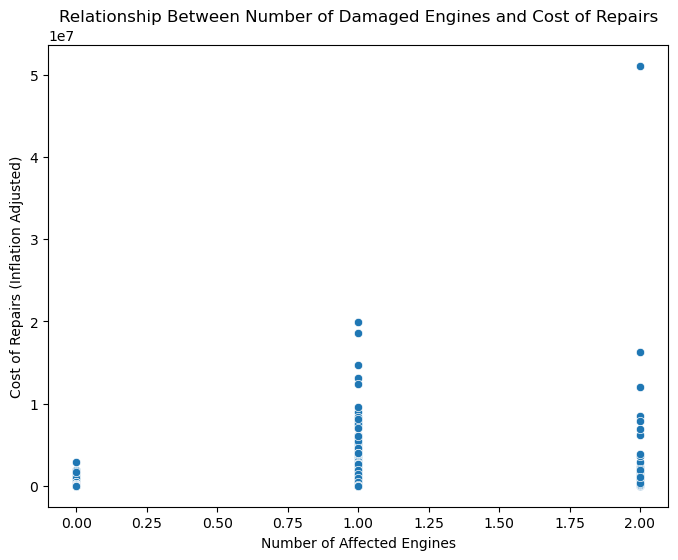

In [33]:
# Scatter plot to visualise the relationship between number of damaged engines and repair costs
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NUM_DAM_ENGINES', y='COST_REPAIRS_INFL_ADJ', data=wildlife_strike_engin)

# Set plot title and labels
plt.title('Relationship Between Number of Damaged Engines and Cost of Repairs')
plt.xlabel('Number of Affected Engines')
plt.ylabel('Cost of Repairs (Inflation Adjusted)')
plt.show()

In [34]:
# Drop engin related cols that are no longer necessary
wildlife_strike_engin_clean = wildlife_strike_engin.drop(wildlife_strike_engin.columns[[7,8,9,10,11,17,18,19,20,21,22,23,24]], axis=1)

### Investigate airport location

Rationale: Affects the species of birds (and therefore their size) in the vicinity and their migration patterns, which affects the strikes and therefore cost of repairs

In [35]:
# Extract unique latitude and longitude for each AIRPORT_ID
airport_coords = wildlife_strike_engin_clean[['AIRPORT_ID', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE']].dropna().drop_duplicates()

# Map the latitudes and longitudes to the rows with missing values
wildlife_strike_engin_clean['AIRPORT_LATITUDE'] = wildlife_strike_engin_clean['AIRPORT_LATITUDE'].fillna(wildlife_strike_engin_clean['AIRPORT_ID'].map(airport_coords.set_index('AIRPORT_ID')['AIRPORT_LATITUDE']))
wildlife_strike_engin_clean['AIRPORT_LONGITUDE'] = wildlife_strike_engin_clean['AIRPORT_LONGITUDE'].fillna(wildlife_strike_engin_clean['AIRPORT_ID'].map(airport_coords.set_index('AIRPORT_ID')['AIRPORT_LONGITUDE']))

wildlife_strike_engin_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108789 entries, 45 to 310726
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         108789 non-null  int64  
 1   TIME_OF_DAY            108789 non-null  object 
 2   AIRPORT_ID             108789 non-null  object 
 3   AIRPORT_LATITUDE       107766 non-null  float64
 4   AIRPORT_LONGITUDE      107765 non-null  float64
 5   AC_MASS                108789 non-null  object 
 6   TYPE_ENG               108789 non-null  object 
 7   SPEED                  108789 non-null  float64
 8   DAMAGE_LEVEL           108789 non-null  object 
 9   DAM_RAD                108789 non-null  bool   
 10  DAM_WINDSHLD           108789 non-null  bool   
 11  DAM_NOSE               108789 non-null  bool   
 12  INGESTED_OTHER         108789 non-null  bool   
 13  DAM_PROP               108789 non-null  bool   
 14  DAM_WING_ROT           108789 non-null  

In [36]:
# Check longitude and latitude, verifying they are within correct range
# Filter out rows with invalid coordinates
wildlife_strike_coord = wildlife_strike_engin_clean[
    (wildlife_strike_engin_clean['AIRPORT_LATITUDE'] >= -90) & 
    (wildlife_strike_engin_clean['AIRPORT_LATITUDE'] <= 90) &
    (wildlife_strike_engin_clean['AIRPORT_LONGITUDE'] >= -180) & 
    (wildlife_strike_engin_clean['AIRPORT_LONGITUDE'] <= 180)
]

# Filter out airport id that has missing longitude and latitude
wildlife_strike_coord[
    wildlife_strike_coord['AIRPORT_ID'].notna() & 
    (wildlife_strike_coord['AIRPORT_LATITUDE'].isna() | wildlife_strike_coord['AIRPORT_LONGITUDE'].isna())]['AIRPORT_ID'].unique()

array([], dtype=object)

In [37]:
! pip install folium
import folium
from folium.plugins import HeatMap

# Prepare the data for the map
strike_counts = wildlife_strike_coord.groupby(['AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE']).size().reset_index(name='STRIKE_COUNT')

# Initialize a map, centered at an average location
map_center = [strike_counts['AIRPORT_LATITUDE'].mean(), strike_counts['AIRPORT_LONGITUDE'].mean()]
wildlife_map = folium.Map(location=map_center, zoom_start=5)

# Add a heatmap layer
heat_data = strike_counts[['AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'STRIKE_COUNT']].values.tolist()
HeatMap(heat_data, radius=10).add_to(wildlife_map)

# Add title to the map
title_html = '''
             <h3 align="center" style="font-size: 20px; font-weight: bold;">Aircraft Wildlife Strike Locations</h3>
             '''
wildlife_map.get_root().html.add_child(folium.Element(title_html))

# Add a custom legend using HTML and CSS
legend_html = """
<div style="position: fixed; 
            bottom: 30px; left: 30px; width: 250px; height: 150px; 
            background-color: white; border:2px solid grey; z-index:9999;
            font-size: 14px; padding: 15px;">
    <strong>Strike Intensity</strong><br>
    <i style="background-color:blue; width: 20px; height: 20px; display: inline-block;"></i> Low<br>
    <i style="background-color:green; width: 20px; height: 20px; display: inline-block;"></i> Moderate<br>
    <i style="background-color:yellow; width: 20px; height: 20px; display: inline-block;"></i> High<br>
    <i style="background-color:red; width: 20px; height: 20px; display: inline-block;"></i> Very High
</div>
"""

# Attach the legend to the map
wildlife_map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
wildlife_map

### Inspect time aircraft was out of service

In [38]:
wildlife_strike_coord['AOS'].describe()

count    7395.000000
mean       81.484955
std       352.278852
min         0.100000
25%         1.000000
50%         2.000000
75%        24.000000
max      6480.000000
Name: AOS, dtype: float64

A total of 7395 non null values in AOS column out of 107764 in the remaining dataset. Taking AOS into consideration may be disregarding several other data points that contain useful data pertaining to repair costs. Besides, the time an aircraft is out of service is not fully indicative of the extent of damage - can be affected by manpower shortages, holiday seasons etc. Thus, **it will be omitted.**

In [39]:
strike_cleaned = wildlife_strike_coord.drop(columns='AOS')
strike_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107764 entries, 45 to 310726
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INCIDENT_MONTH         107764 non-null  int64  
 1   TIME_OF_DAY            107764 non-null  object 
 2   AIRPORT_ID             107764 non-null  object 
 3   AIRPORT_LATITUDE       107764 non-null  float64
 4   AIRPORT_LONGITUDE      107764 non-null  float64
 5   AC_MASS                107764 non-null  object 
 6   TYPE_ENG               107764 non-null  object 
 7   SPEED                  107764 non-null  float64
 8   DAMAGE_LEVEL           107764 non-null  object 
 9   DAM_RAD                107764 non-null  bool   
 10  DAM_WINDSHLD           107764 non-null  bool   
 11  DAM_NOSE               107764 non-null  bool   
 12  INGESTED_OTHER         107764 non-null  bool   
 13  DAM_PROP               107764 non-null  bool   
 14  DAM_WING_ROT           107764 non-null  

### EDA & minor tweaks

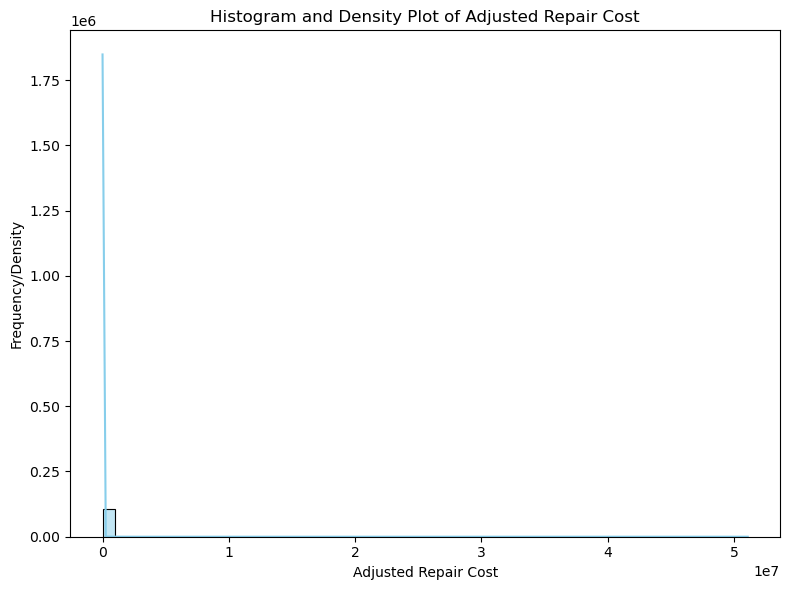

In [40]:
# Visualise the distribution of repair costs

# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(strike_cleaned['COST_REPAIRS_INFL_ADJ'], kde=True, color='skyblue', bins=50)
plt.title('Histogram and Density Plot of Adjusted Repair Cost')
plt.xlabel('Adjusted Repair Cost')
plt.ylabel('Frequency/Density')
plt.tight_layout()
plt.show()

# heavily skewed distribution, to apply log transformation
import numpy as np

# Apply log1p transformation to handle zero values
for col in ['COST_REPAIRS_INFL_ADJ']:  # You can extend this to other columns in your dataset
    if (strike_cleaned[col] < 0).any():
        print(f"Column {col} contains negative values, log transformation skipped.")
    else:
        # Apply log1p transformation (log(1 + x) handles 0 and small positive values)
        strike_cleaned[f'log1p_{col}'] = np.log1p(strike_cleaned[col])

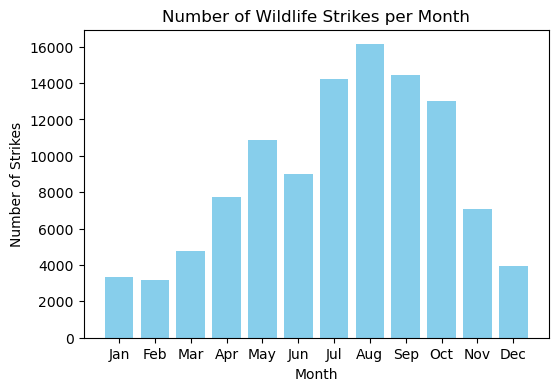

In [41]:
# Group by INCIDENT_MONTH and count the number of strikes
monthly_strikes = strike_cleaned.groupby('INCIDENT_MONTH').size().reset_index(name='STRIKE_COUNT')

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(monthly_strikes['INCIDENT_MONTH'], monthly_strikes['STRIKE_COUNT'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Strikes')
plt.title('Number of Wildlife Strikes per Month')
plt.xticks(monthly_strikes['INCIDENT_MONTH'], 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

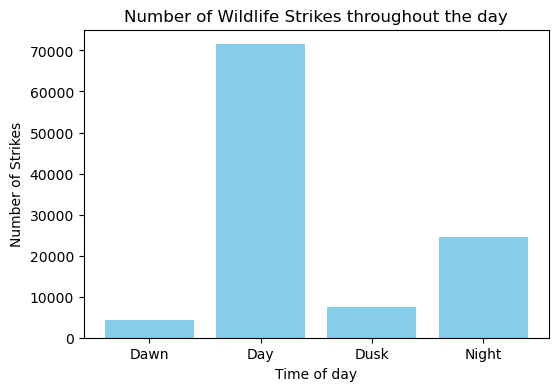

In [42]:
# Group by time of day and count the number of strikes
time_strikes = strike_cleaned.groupby('TIME_OF_DAY').size().reset_index(name='STRIKE_COUNT')

# Plot the data
plt.figure(figsize=(6,4))
plt.bar(time_strikes['TIME_OF_DAY'], time_strikes['STRIKE_COUNT'], color='skyblue')
plt.xlabel('Time of day')
plt.ylabel('Number of Strikes')
plt.title('Number of Wildlife Strikes throughout the day')
plt.xticks(time_strikes['TIME_OF_DAY'])
plt.show()

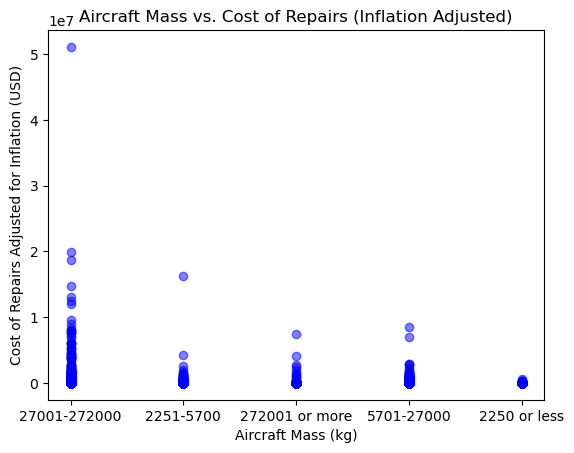

In [43]:
# Scatter plot of aircraft mass against cost of repairs
plt.scatter(strike_cleaned['AC_MASS'],strike_cleaned['COST_REPAIRS_INFL_ADJ'], color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Aircraft Mass (kg)')
plt.ylabel('Cost of Repairs Adjusted for Inflation (USD)')
plt.title('Aircraft Mass vs. Cost of Repairs (Inflation Adjusted)')

# Display the plot
plt.show()

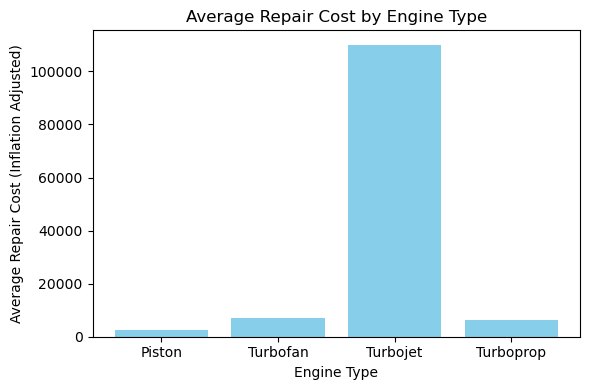

In [44]:
# Visualize the relationship between TYPE_ENG (engine type) and COST_REPAIRS_INFL_ADJ (adjusted repair cost)
# Group by engine type and calculate mean cost
eng_cost_summary = strike_cleaned.groupby('TYPE_ENG')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
eng_cost_summary.columns = ['Engine Type', 'Average Repair Cost']

# plot data
plt.figure(figsize=(6, 4))
plt.bar(eng_cost_summary['Engine Type'], eng_cost_summary['Average Repair Cost'], color='skyblue')
plt.xlabel('Engine Type')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Engine Type')
plt.tight_layout()
plt.show()

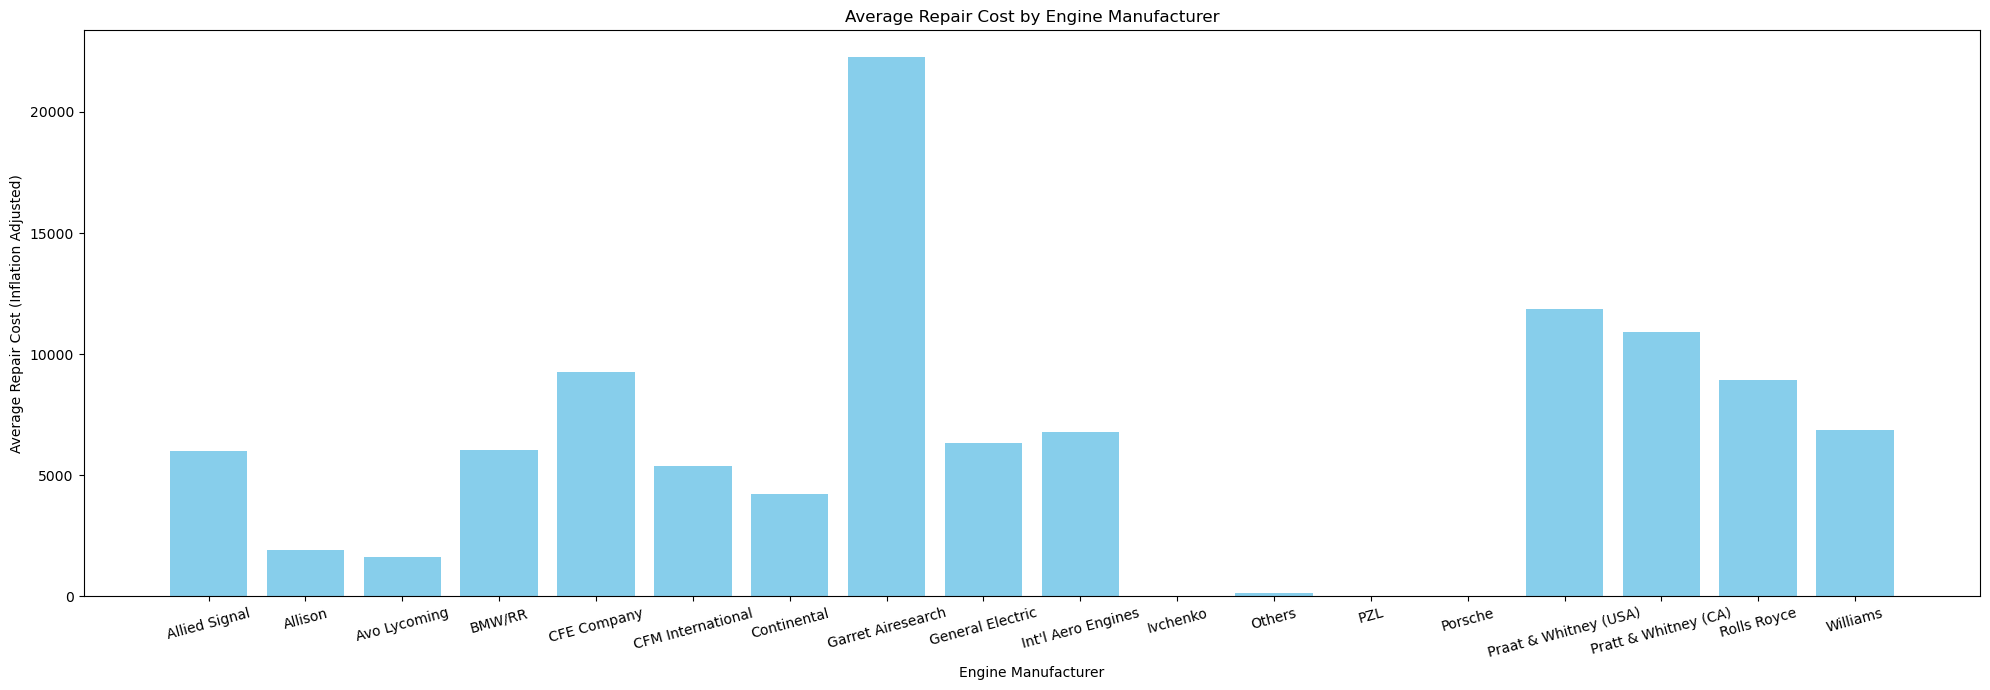

In [45]:
# Visualize the relationship between manufacturer of engine and adjusted repair cost
# Group by engine manufacturer and calculate mean cost
manu_cost_summary = strike_cleaned.groupby('ENGIN_MANUFACTURER')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
manu_cost_summary.columns = ['Engine Manufacturer', 'Average Repair Cost']

# plot data
plt.figure(figsize=(20, 7))
plt.bar(manu_cost_summary['Engine Manufacturer'], manu_cost_summary['Average Repair Cost'], color='skyblue')
plt.xlabel('Engine Manufacturer')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Engine Manufacturer')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

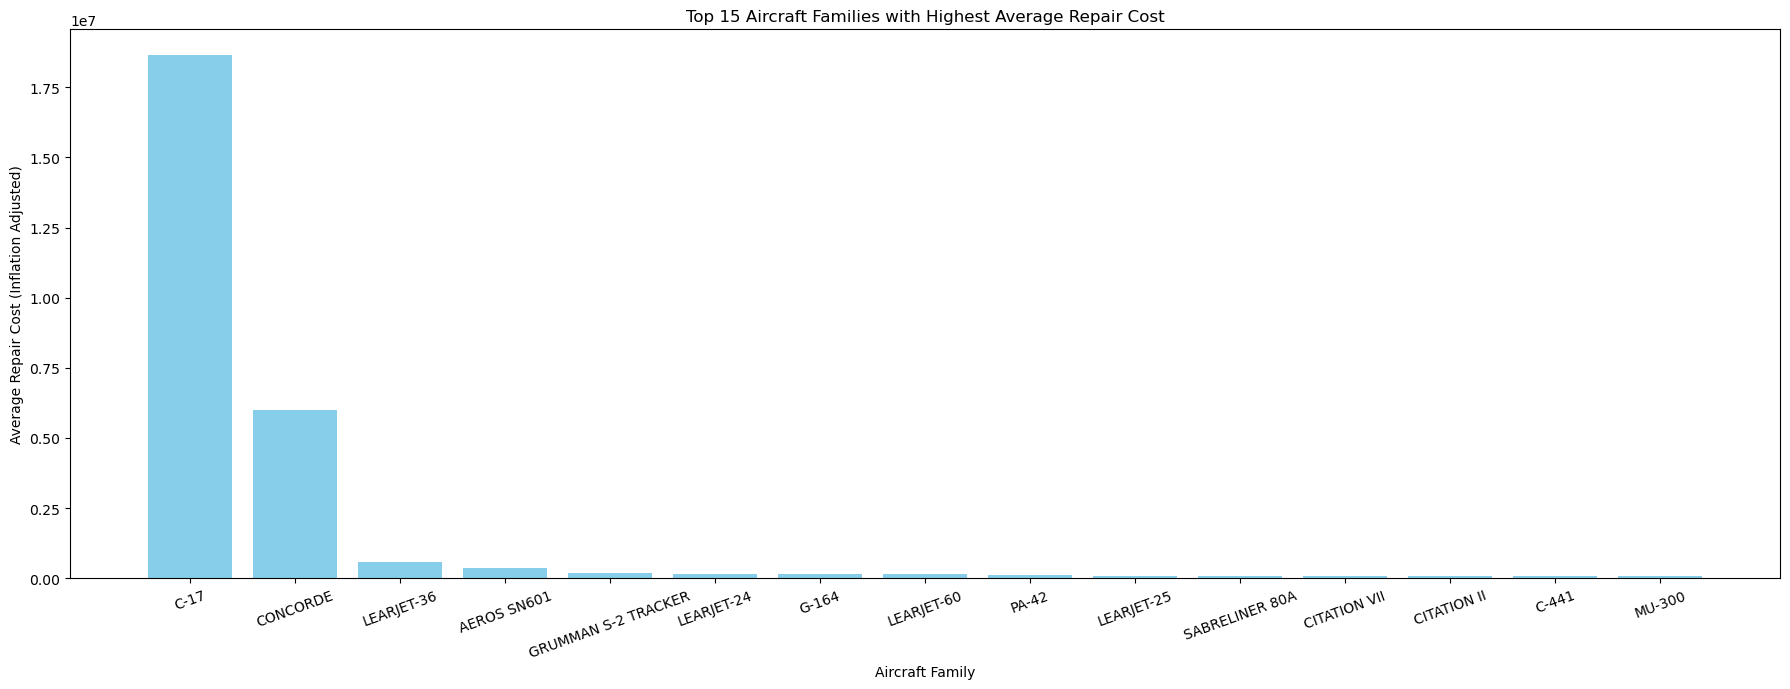

In [46]:
# Visualize the relationship between aircraft family and adjusted repair cost
# Group by aircraft family and calculate mean cost
aircraft_fam_cost = strike_cleaned.groupby('AIRCRAFT_FAMILY')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
aircraft_fam_cost.columns = ['Aircraft Family', 'Average Repair Cost']

# Filter out top 15 aircraft families with highest cost (too many aircraft families for visualisation)
top_15_aircraft_fam_cost = aircraft_fam_cost[
    aircraft_fam_cost['Average Repair Cost'] > 0].sort_values(by='Average Repair Cost', ascending=False).head(15)

# Plot data
plt.figure(figsize=(18, 7))
plt.bar(top_15_aircraft_fam_cost['Aircraft Family'], top_15_aircraft_fam_cost['Average Repair Cost'], color='skyblue')
plt.xlabel('Aircraft Family')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Top 15 Aircraft Families with Highest Average Repair Cost')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

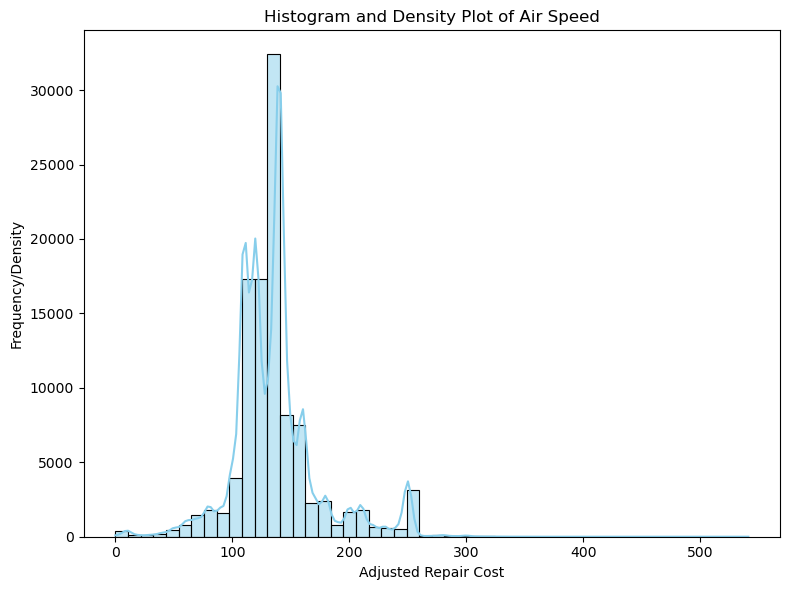

In [47]:
# Speed distribution
plt.figure(figsize=(8, 6))
sns.histplot(strike_cleaned['SPEED'], kde=True, color='skyblue', bins=50)
plt.title('Histogram and Density Plot of Air Speed')
plt.xlabel('Adjusted Repair Cost')
plt.ylabel('Frequency/Density')
plt.tight_layout()
plt.show()

# normal ish distributed

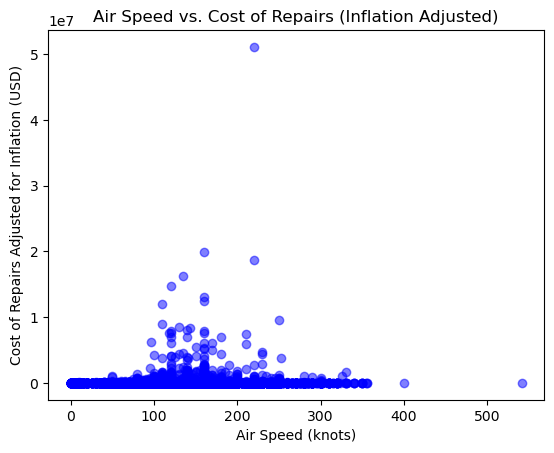

In [48]:
# Scatter plot of aircraft speed against cost of repairs
plt.scatter(strike_cleaned['SPEED'],strike_cleaned['COST_REPAIRS_INFL_ADJ'], color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Air Speed (knots)')
plt.ylabel('Cost of Repairs Adjusted for Inflation (USD)')
plt.title('Air Speed vs. Cost of Repairs (Inflation Adjusted)')
plt.show()

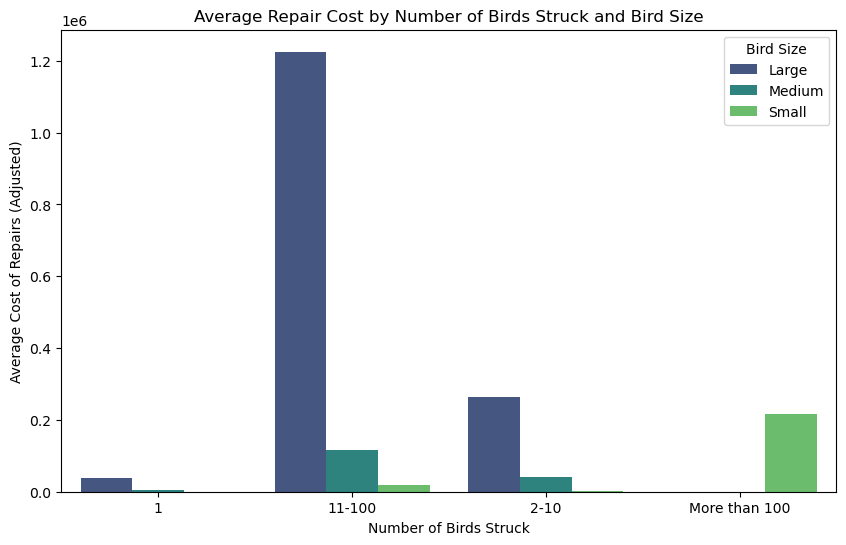

In [49]:
# Visualise relationship between cost and NUM_STRUCK and SIZE
grouped_data = strike_cleaned.groupby(['NUM_STRUCK', 'SIZE'])['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='NUM_STRUCK', y='COST_REPAIRS_INFL_ADJ', hue='SIZE', data=grouped_data, palette='viridis')
plt.xlabel('Number of Birds Struck')
plt.ylabel('Average Cost of Repairs (Adjusted)')
plt.title('Average Repair Cost by Number of Birds Struck and Bird Size')
plt.legend(title='Bird Size')
plt.show()

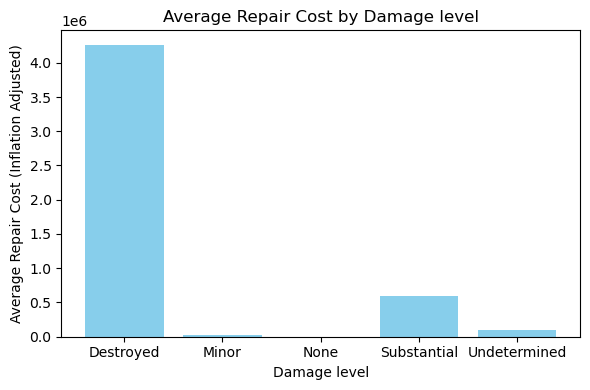

In [50]:
# Visualize the relationship between damage level and adjusted repair cost
# Group by engine manufacturer and calculate mean cost
damagelev_cost = strike_cleaned.groupby('DAMAGE_LEVEL')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
damagelev_cost.columns = ['Damage level', 'Average Repair Cost']

# plot data
plt.figure(figsize=(6, 4))
plt.bar(damagelev_cost['Damage level'], damagelev_cost['Average Repair Cost'], color='skyblue')
plt.xlabel('Damage level')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Damage level')
plt.tight_layout()
plt.show()

In [51]:
# Attempt to refine airport id
strike_cleaned['AIRPORT_ID'].value_counts(normalize=True)*100

# Values are all rather sparse across the different airport ids, hard to bin. will leave it

AIRPORT_ID
KDEN    3.126276
KMEM    2.715192
KDFW    2.344939
KSMF    2.126870
KORD    1.715786
KCLT    1.688876
KSLC    1.584945
KPHL    1.570098
KSDF    1.561746
KJFK    1.540403
KLGA    1.504213
KMCO    1.394714
KATL    1.367804
KEWR    1.353884
KMCI    1.323262
KBNA    1.218403
KLAX    1.190565
KDTW    1.168294
KAUS    1.146023
KPDX    1.120968
KBOS    1.101481
KBWI    1.095913
KSTL    1.043020
KIAH    1.032812
KIND    0.978063
KFLL    0.954864
KSFO    0.945585
KMSP    0.891763
KOAK    0.854645
KCVG    0.831446
KOMA    0.816599
KIAD    0.796184
KHOU    0.794328
KSEA    0.792472
KSAT    0.790617
KCLE    0.787833
KPIT    0.763706
KMIA    0.758138
KRSW    0.743291
KCMH    0.742363
KSJC    0.735867
KDAL    0.734939
KMDW    0.734939
KMSY    0.674622
KTPA    0.635648
KMDT    0.608738
KDCA    0.602242
KPHX    0.598530
KJAX    0.555844
KRDU    0.545637
KSFB    0.531717
PHNL    0.492743
KBUF    0.472328
KDSM    0.470473
KMKE    0.470473
KONT    0.469545
KBDL    0.454697
PHLI    0.431498
KBH

#### Further feature engineering for engine interaction term

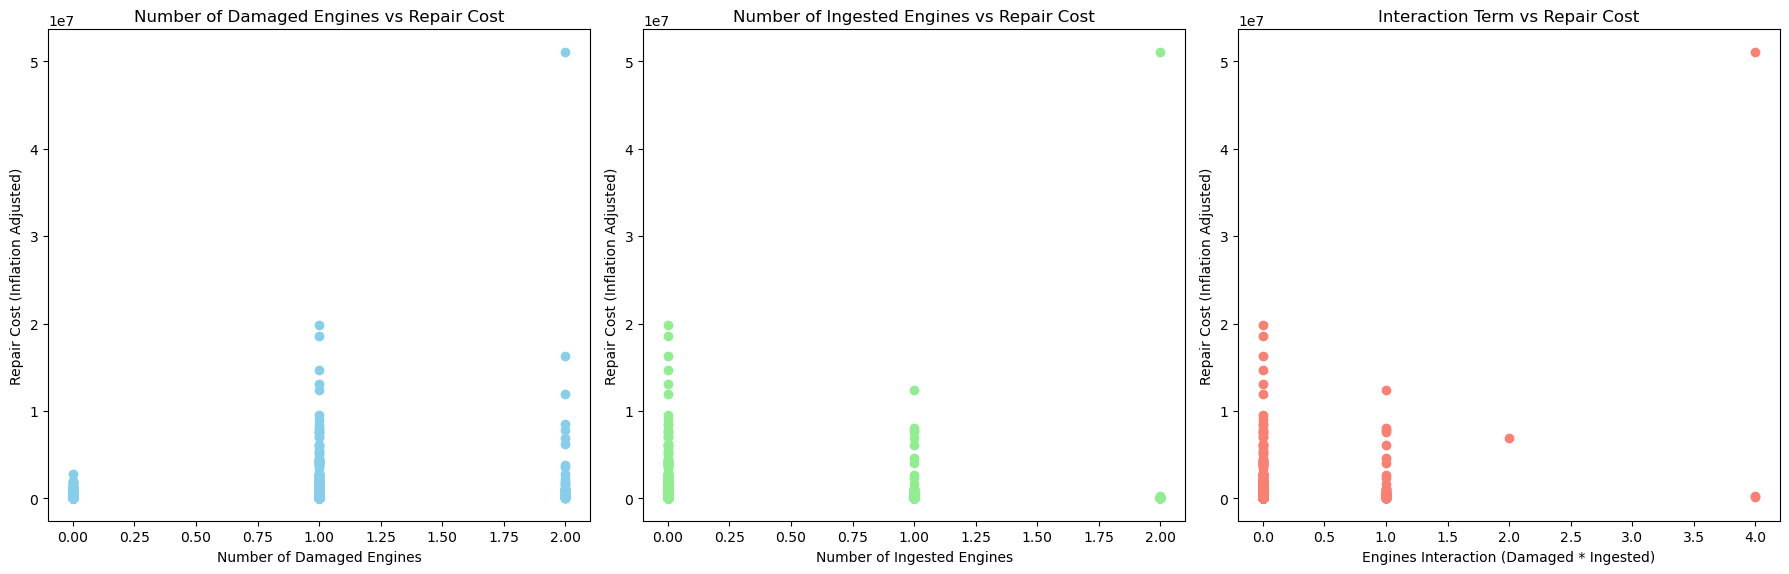

In [52]:
# Create interaction term between num of damaged and ingested engines, as engines are the most expensive to repair and an interaction term may be able to better advise impact of engine damage/ingestion on cost
strike_cleaned['ENGINES_INTERACTION'] = strike_cleaned['NUM_DAM_ENGINES'] * strike_cleaned['NUM_ING_ENGINES']

# Set up the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot NUM_DAM_ENGINES vs COST_REPAIRS_INFL_ADJ
axes[0].scatter(strike_cleaned['NUM_DAM_ENGINES'], strike_cleaned['COST_REPAIRS_INFL_ADJ'], color='skyblue')
axes[0].set_title('Number of Damaged Engines vs Repair Cost')
axes[0].set_xlabel('Number of Damaged Engines')
axes[0].set_ylabel('Repair Cost (Inflation Adjusted)')

# Plot NUM_ING_ENGINES vs COST_REPAIRS_INFL_ADJ
axes[1].scatter(strike_cleaned['NUM_ING_ENGINES'], strike_cleaned['COST_REPAIRS_INFL_ADJ'], color='lightgreen')
axes[1].set_title('Number of Ingested Engines vs Repair Cost')
axes[1].set_xlabel('Number of Ingested Engines')
axes[1].set_ylabel('Repair Cost (Inflation Adjusted)')

# Plot ENGINES_INTERACTION vs COST_REPAIRS_INFL_ADJ
axes[2].scatter(strike_cleaned['ENGINES_INTERACTION'], strike_cleaned['COST_REPAIRS_INFL_ADJ'], color='salmon')
axes[2].set_title('Interaction Term vs Repair Cost')
axes[2].set_xlabel('Engines Interaction (Damaged * Ingested)')
axes[2].set_ylabel('Repair Cost (Inflation Adjusted)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
# Drop columns that will not be used in eventual set
prelim_data = strike_cleaned.drop(strike_cleaned.columns[[3,4]], axis=1)

# Preliminary save for ease of continuation for 2nd part
prelim_data.to_csv('prelim_data.csv', index=False)

In [ ]:
# Load file for fail save
prelim_data = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY695/Assignment/prelim_data.csv')

prelim_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107764 entries, 45 to 310726
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   INCIDENT_MONTH               107764 non-null  int64  
 1   TIME_OF_DAY                  107764 non-null  object 
 2   AIRPORT_ID                   107764 non-null  object 
 3   AC_MASS                      107764 non-null  object 
 4   TYPE_ENG                     107764 non-null  object 
 5   SPEED                        107764 non-null  float64
 6   DAMAGE_LEVEL                 107764 non-null  object 
 7   DAM_RAD                      107764 non-null  bool   
 8   DAM_WINDSHLD                 107764 non-null  bool   
 9   DAM_NOSE                     107764 non-null  bool   
 10  INGESTED_OTHER               107764 non-null  bool   
 11  DAM_PROP                     107764 non-null  bool   
 12  DAM_WING_ROT                 107764 non-null  bool   
 13  DAM

#### Dummify categorical variables, then correlation check

In [ ]:
cols_dummy = ['TIME_OF_DAY', 'AIRPORT_ID', 'AC_MASS', 'TYPE_ENG', 'DAMAGE_LEVEL', 'NUM_STRUCK', 'SIZE', 'AIRCRAFT_FAMILY', 'ENGIN_MANUFACTURER']

# Check for collinearity between variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

x = prelim_data.drop(columns=['COST_REPAIRS_INFL_ADJ', 'log1p_COST_REPAIRS_INFL_ADJ'])
x_vifcheck = x.select_dtypes(include=['float64', 'int64'])

x_vifcheck = sm.add_constant(x_vifcheck)
vif = pd.DataFrame()
vif['Feature'] = x_vifcheck.columns
vif['VIF'] = [variance_inflation_factor(x_vifcheck.values, i) for i in range(x_vifcheck.shape[1])]

print(vif.sort_values(by='VIF', ascending=False))

# Among numerical variables, no multicollinearity observed

               Feature        VIF
0                const  20.959143
5  ENGINES_INTERACTION   1.158475
3      NUM_DAM_ENGINES   1.086058
4      NUM_ING_ENGINES   1.072366
2                SPEED   1.000556
1       INCIDENT_MONTH   1.000531


In [ ]:
# Correlation between airport id and cost - too many different values. little value in running this
#airport_dummy = pd.get_dummies(prelim_data[['AIRPORT_ID']], drop_first=True)
#df_test = pd.concat([airport_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
#df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

In [56]:
# Correlation between time of day and cost
time_dummy = pd.get_dummies(prelim_data[['TIME_OF_DAY']], drop_first=True)
df_test = pd.concat([time_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ    1.000000
TIME_OF_DAY_Dusk               0.017633
TIME_OF_DAY_Night              0.011749
TIME_OF_DAY_Day               -0.020894
Name: log1p_COST_REPAIRS_INFL_ADJ, dtype: float64

In [57]:
# Correlation between aircraft masss and cost
mass_dummy = pd.get_dummies(prelim_data[['AC_MASS']], drop_first=True)
df_test = pd.concat([mass_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ    1.000000
AC_MASS_2251-5700              0.109661
AC_MASS_5701-27000             0.019978
AC_MASS_272001 or more         0.007731
AC_MASS_27001-272000          -0.117580
Name: log1p_COST_REPAIRS_INFL_ADJ, dtype: float64

In [58]:
# Correlation between type of engin and cost
engin_dummy = pd.get_dummies(prelim_data[['TYPE_ENG']], drop_first=True)
df_test = pd.concat([engin_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ    1.000000
TYPE_ENG_Turboprop             0.042755
TYPE_ENG_Turbojet              0.024668
TYPE_ENG_Turbofan             -0.118009
Name: log1p_COST_REPAIRS_INFL_ADJ, dtype: float64

In [59]:
# Correlation between damage level and cost
dam_dummy = pd.get_dummies(prelim_data[['DAMAGE_LEVEL']], drop_first=True)
df_test = pd.concat([dam_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ    1.000000
DAMAGE_LEVEL_Substantial       0.630066
DAMAGE_LEVEL_Undetermined      0.524463
DAMAGE_LEVEL_Minor             0.512324
DAMAGE_LEVEL_None             -0.973892
Name: log1p_COST_REPAIRS_INFL_ADJ, dtype: float64

In [ ]:
# Filter out damage predictors and check correlation with cost
damage_check = prelim_data[['DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_PROP', 'DAM_WING_ROT', 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER', 'NUM_DAM_ENGINES', 'NUM_ING_ENGINES', 'DAMAGE_LEVEL', 'ENGINES_INTERACTION', 'INGESTED_OTHER']]

# Convert DAMAGE_LEVEL to dummies
damage_check = pd.get_dummies(damage_check, columns=['DAMAGE_LEVEL'], drop_first=True)

# Convert boolean to int
damage_check = damage_check.applymap(lambda x: 1 if x == True else 0)

# Add a constant
damage_check = sm.add_constant(damage_check)

# Calculate VIF
vif = pd.DataFrame()
vif["Feature"] = damage_check.columns
vif["VIF"] = [variance_inflation_factor(damage_check.values, i) for i in range(damage_check.shape[1])]

print(vif.sort_values(by="VIF", ascending=False))

# Damage level might be more indicative as a whole but it is also more subjective. will keep all for now but good chances damage level will have more impact 

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/218049750.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  damage_check = damage_check.applymap(lambda x: 1 if x == True else 0)


                      Feature          VIF
0                       const  6941.925241
16          DAMAGE_LEVEL_None   180.823062
15         DAMAGE_LEVEL_Minor    63.333155
17   DAMAGE_LEVEL_Substantial    51.071117
18  DAMAGE_LEVEL_Undetermined    49.155236
11            NUM_DAM_ENGINES     2.677966
5                DAM_WING_ROT     2.341153
1                     DAM_RAD     1.355454
7                      DAM_LG     1.260241
10                  DAM_OTHER     1.223195
13        ENGINES_INTERACTION     1.219617
3                    DAM_NOSE     1.216098
4                    DAM_PROP     1.213929
6                    DAM_FUSE     1.194189
8                    DAM_TAIL     1.132932
2                DAM_WINDSHLD     1.129284
14             INGESTED_OTHER     1.126562
9                   DAM_LGHTS     1.120630
12            NUM_ING_ENGINES     1.083084


/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_43862/4070855706.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dam_corr_check = dam_corr_check.applymap(lambda x: 1 if x is True else (0 if x is False else x))


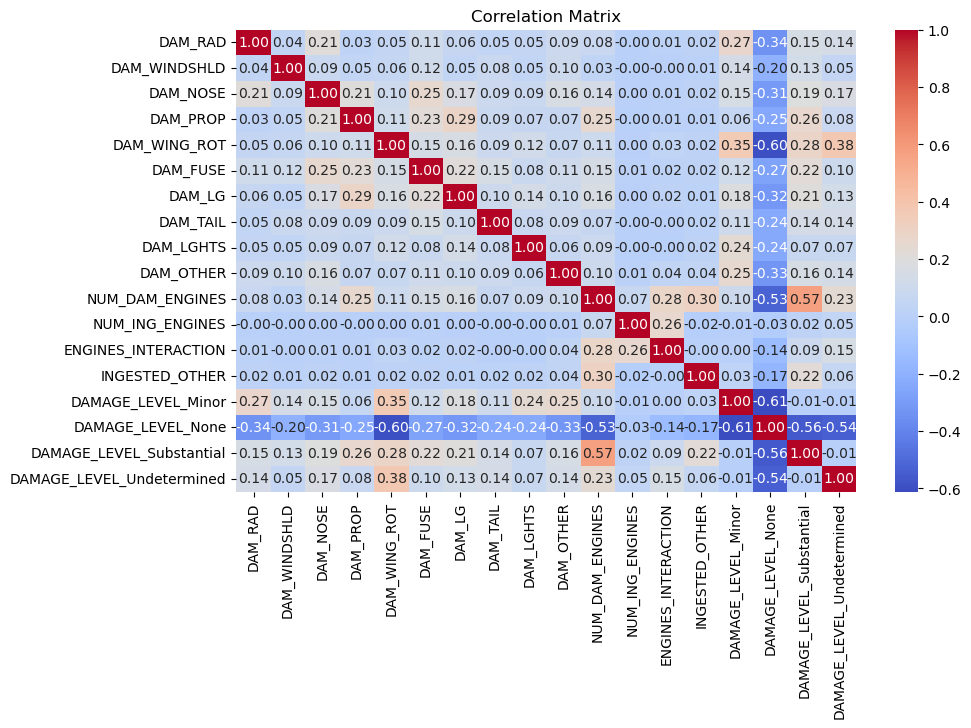

In [76]:
# Checking for correlation between the damage predictors
cols_to_check = ['DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_PROP', 'DAM_WING_ROT', 
                 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER', 
                 'NUM_DAM_ENGINES', 'NUM_ING_ENGINES', 'DAMAGE_LEVEL', 
                 'ENGINES_INTERACTION', 'INGESTED_OTHER']

# Create a subset of the DataFrame
dam_corr_check = prelim_data[cols_to_check]

# Convert boolean columns to integers & dummify
dam_corr_check = dam_corr_check.applymap(lambda x: 1 if x is True else (0 if x is False else x))
dam_corr_check = pd.get_dummies(dam_corr_check, columns=['DAMAGE_LEVEL'], drop_first=True)

# Compute the correlation matrix
correlation_matrix = dam_corr_check.corr()

# Visualise correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [60]:
# Correlation between number of wildlife struck and cost
struck_dummy = pd.get_dummies(prelim_data[['NUM_STRUCK']], drop_first=True)
df_test = pd.concat([struck_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ    1.000000
NUM_STRUCK_2-10                0.043237
NUM_STRUCK_11-100              0.026426
NUM_STRUCK_More than 100       0.022349
Name: log1p_COST_REPAIRS_INFL_ADJ, dtype: float64

In [61]:
# Correlation between size and cost
size_dummy = pd.get_dummies(prelim_data[['SIZE']], drop_first=True)
df_test = pd.concat([size_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ    1.000000
SIZE_Medium                    0.060314
SIZE_Small                    -0.195792
Name: log1p_COST_REPAIRS_INFL_ADJ, dtype: float64

In [62]:
# Correlation between aircraft family and cost
acfam_dummy = pd.get_dummies(prelim_data[['AIRCRAFT_FAMILY']], drop_first=True)
df_test = pd.concat([acfam_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ                 1.000000
AIRCRAFT_FAMILY_PA-28                       0.045620
AIRCRAFT_FAMILY_C-650                       0.042664
AIRCRAFT_FAMILY_C-500                       0.042503
AIRCRAFT_FAMILY_CITATION II                 0.040957
AIRCRAFT_FAMILY_BE-35                       0.040205
AIRCRAFT_FAMILY_C-550                       0.037705
AIRCRAFT_FAMILY_SA226 TC                    0.037402
AIRCRAFT_FAMILY_C-172                       0.036046
AIRCRAFT_FAMILY_LEARJET-35                  0.035134
AIRCRAFT_FAMILY_BE-36                       0.035050
AIRCRAFT_FAMILY_PA-32                       0.033801
AIRCRAFT_FAMILY_BA-31                       0.031126
AIRCRAFT_FAMILY_MOONEY M20                  0.030955
AIRCRAFT_FAMILY_C-210                       0.030908
AIRCRAFT_FAMILY_C-182                       0.030695
AIRCRAFT_FAMILY_BE-200                      0.030662
AIRCRAFT_FAMILY_C-17                        0.030278
AIRCRAFT_FAMILY_LEARJET-25                  0.

In [63]:
# Correlation between aircraft family and cost
manu_dummy = pd.get_dummies(prelim_data[['ENGIN_MANUFACTURER']], drop_first=True)
df_test = pd.concat([manu_dummy, prelim_data['log1p_COST_REPAIRS_INFL_ADJ']], axis=1)
df_test.corr()['log1p_COST_REPAIRS_INFL_ADJ'].sort_values(ascending=False)

log1p_COST_REPAIRS_INFL_ADJ                 1.000000
ENGIN_MANUFACTURER_Garret Airesearch        0.094546
ENGIN_MANUFACTURER_Continental              0.081568
ENGIN_MANUFACTURER_Avo Lycoming             0.079037
ENGIN_MANUFACTURER_Pratt & Whitney (CA)     0.066706
ENGIN_MANUFACTURER_Williams                 0.026850
ENGIN_MANUFACTURER_CFE Company              0.009629
ENGIN_MANUFACTURER_Others                   0.003502
ENGIN_MANUFACTURER_Porsche                 -0.000492
ENGIN_MANUFACTURER_Ivchenko                -0.000492
ENGIN_MANUFACTURER_PZL                     -0.000852
ENGIN_MANUFACTURER_Rolls Royce             -0.002675
ENGIN_MANUFACTURER_BMW/RR                  -0.009450
ENGIN_MANUFACTURER_Praat & Whitney (USA)   -0.015303
ENGIN_MANUFACTURER_Allison                 -0.020866
ENGIN_MANUFACTURER_Int'l Aero Engines      -0.028492
ENGIN_MANUFACTURER_General Electric        -0.036656
ENGIN_MANUFACTURER_CFM International       -0.056010
Name: log1p_COST_REPAIRS_INFL_ADJ, dtype: floa

In [78]:
# Final model 
final_data = prelim_data.drop(columns=['COST_REPAIRS_INFL_ADJ'])
final_data = pd.get_dummies(final_data, columns=cols_dummy, drop_first=True)

### Modelling

In [87]:
# Construct the feature matrix and target vector
X = final_data.drop('log1p_COST_REPAIRS_INFL_ADJ', axis=1)
y = final_data['log1p_COST_REPAIRS_INFL_ADJ']

# Separate the data into training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5) 

# Standardisation of data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
cols_standardise = X.select_dtypes(include=['number']).columns.tolist()

# Duplicate data for predictor to apply std
x_train_std = x_train.copy()
x_test_std = x_test.copy()
x_train_std[cols_standardise] = scaler.fit_transform(x_train_std[cols_standardise])
x_test_std[cols_standardise] = scaler.transform(x_test_std[cols_standardise]) 

In [ ]:
# Build LASSO Regression model
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.001)
lasso_model = lasso.fit(x_train_std,y_train)

# Retrieving features by LASSO - consider applying to random forest
lasso_coef = lasso_model.coef_
lasso_features = lasso_coef != 0
lasso_feature_names = x_train_std.columns[lasso_features]
print('Number of selected features using LASSO:', len(lasso_feature_names))

# Create DataFrame of predictor and its coefficient with non 0 values
lasso_coef_df = pd.DataFrame(list(zip(x_train_std.columns, lasso_coef)), columns=['predictor', 'coefficient'])
lasso_coef_df_non_zero = lasso_coef_df[lasso_coef_df['coefficient'] != 0]
lasso_coef_df_non_zero

Number of selected features using LASSO: 19


,predictor,coefficient
1,SPEED,0.010438
2,DAM_RAD,0.801137
5,INGESTED_OTHER,0.025543
7,DAM_WING_ROT,0.420035
11,DAM_LGHTS,-0.184037
13,NUM_DAM_ENGINES,0.159393
15,ENGINES_INTERACTION,0.022461
1937,AC_MASS_5701-27000,0.002787
1938,TYPE_ENG_Turbofan,0.058152
1940,TYPE_ENG_Turboprop,0.009501


In [101]:
# Retrain the Lasso model with the selected features
lasso_model = Lasso(alpha=0.001)
x_train_selected = x_train_std[lasso_feature_names]
lasso_model.fit(x_train_selected, y_train)

# Apply the same transformation to the test set
x_test_selected = x_test_std[lasso_feature_names]

# Make predictions using the Lasso model on the test set
y_pred = lasso_model.predict(x_test_selected)

from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_squared_error

# Calculate performance metrics
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred) )
print("R-squared:", r2_score(y_test, y_pred) )

Mean Absolute Error (MAE): 0.05105571209253376
Mean Squared Error (MSE): 0.0784027351673498
R-squared: 0.9703682339904177


In [ ]:
# Finetune lasso model using randomized search cross validation
from sklearn.model_selection import RandomizedSearchCV

# Range of alpha values to test
alpha_range = np.logspace(-4, 1, 200)

# Create a Lasso model
lasso = Lasso()

# Set up RandomizedSearchCV
param_dist = {'alpha': alpha_range}
random_search = RandomizedSearchCV(estimator=lasso, param_distributions=param_dist, 
                                   scoring='neg_mean_squared_error', cv=5, n_iter=20, random_state=42)

# Fit the RandomizedSearchCV model
random_search.fit(x_train_selected, y_train)

# Best alpha found
print("Best alpha value:", random_search.best_params_['alpha'])

# Fit the best model from the random search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(x_test_selected)
mse = mean_squared_error(y_test, y_pred)

# Print the final MSE score
print("Final Mean Squared Error (MSE):", mse)

Best alpha value: 0.00023816855519761583
Final Mean Squared Error (MSE): 0.07784757868036013


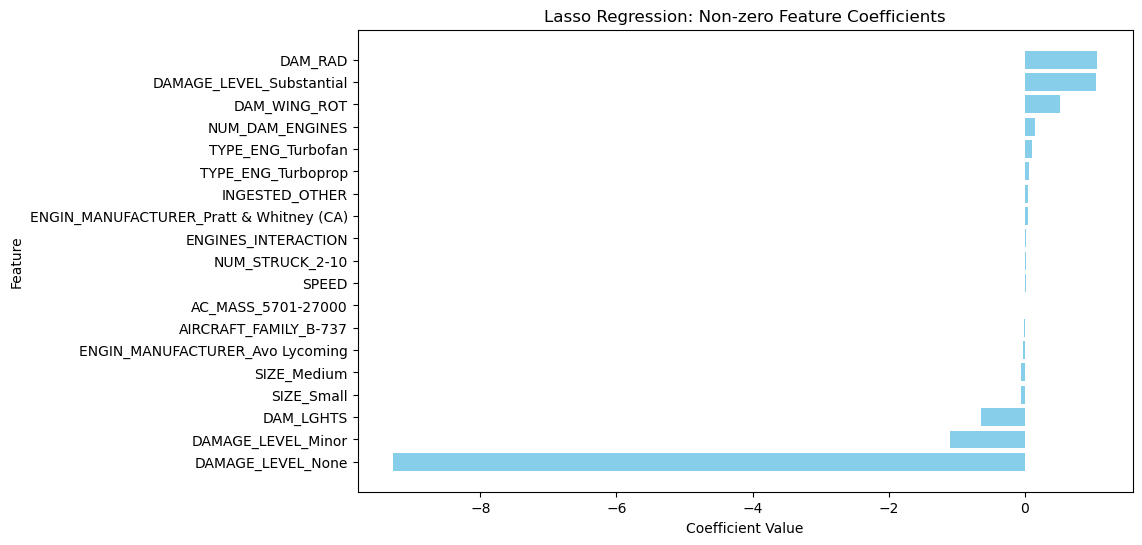

In [104]:
# Get oefficients of the best model
lasso_coef = best_model.coef_

# Get the feature names corresponding to the coefficients
non_zero_features = np.where(lasso_coef != 0)[0]
non_zero_coef = lasso_coef[non_zero_features]
non_zero_feature_names = x_train_selected.columns[non_zero_features]

# Store feature names and their coefficients
features_coef = pd.DataFrame({
    'Feature': non_zero_feature_names,
    'Coefficient': non_zero_coef
})
features_coef = features_coef.sort_values(by='Coefficient', ascending=False)

# Plot the non-zero features and their coefficients
plt.figure(figsize=(10,6))
plt.barh(features_coef['Feature'], features_coef['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Lasso Regression: Non-zero Feature Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to display the largest coefficient on top
plt.show()